#### Temporal Object Detection (Proof-of-Concept)
* Objective: Verify the persistence of objects detected in the 2023 baseline across predictions from previous years (e.g., 2022, 2021, etc.).
* Baseline : 2023 final post-processing output(excluding building footprint filtering)
`/shared/data/climateplus2025/Postprocessing_EntireDataset_CapeTown_Image_2018_2023_Mask2Former_1024_Nov29/2023/output_post_processing_polygonization_grouping_drop_small_objects/prediction_merged_2023_final_visualization.gpkg`

* Unique Key: 'prediction_id' from the 2023 baseline is used as the unique key to track objects across temporal comparisons.

* Methods : An object is considered a 'MATCH' only if ALL THREE criteria are met:
    1. Centroid Proximity (Distance): Euclidean distance between object centroids 
        must be less than or equal to 1 meter (<= 1.0m). This accounts for georeferencing 
        and minor model prediction shifts.
    2. Overlap Ratio (IOU): Intersection Over Union (IOU) of the two polygons 
        must be greater than or equal to 80% (>= 0.80).
    3. Same Class: The predicted 'label' of the objects must be identical (e.g., both 'PV_heater').


* Consideration
    - Grid Search is required to set the best threshold(IOU, Distance)
    - Visualization check-up

**Data Feature Check**

In [16]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import numpy as np
import math
from shapely.geometry import Polygon
from typing import List, Tuple, Optional
from tqdm.auto import tqdm 

# --- Configuration ---
SPECIFIC_GPKG_PATH = "/shared/data/climateplus2025/Postprocessing_EntireDataset_CapeTown_Image_2018_2023_Mask2Former_1024_Nov29/2023/output_post_processing_polygonization_grouping_drop_small_objects/prediction_merged_2023_final_visualization.gpkg"

try:
    # 1. Load the GeoDataFrame
    gdf_sample = gpd.read_file(SPECIFIC_GPKG_PATH, layer='prediction_merged_2023_final_visualization')

    print(f" File Loaded Successfully: {Path(SPECIFIC_GPKG_PATH).name}")
    
    # 2. Print all column names
    print("\n All Column Names:")
    print(list(gdf_sample.columns))
    
    # 3. Print the first 5 rows of all columns
    print("Top 5 Rows (All Columns):")
    print(gdf_sample.head())

except FileNotFoundError:
    print(f"Error: File not found at the specified path: {SPECIFIC_GPKG_PATH}")
except Exception as e:
    print(f"Error occurred while loading the file: {e}")

 File Loaded Successfully: prediction_merged_2023_final_visualization.gpkg

 All Column Names:
['prediction_id', 'image_id', 'label', 'area_m2', 'polygon_centroid_pixel_y_x_', 'polygon_centroid_CRS_X_Y_', 'polygon_centroid_GPS_lat_lon_', 'source_pred_ids', 'merge_size', 'vertex_count', 'geometry']
Top 5 Rows (All Columns):
                                       prediction_id                image_id  \
0  i_2023_RGB_8cm_W13A_6_pred_63b21368;;i_2023_RG...   i_2023_RGB_8cm_W13A_6   
1  i_2023_RGB_8cm_W16C_20_pred_2e4ddf1a;;i_2023_R...  i_2023_RGB_8cm_W16C_20   
2  i_2023_RGB_8cm_W16D_21_pred_9d5bbc9b;;i_2023_R...  i_2023_RGB_8cm_W16D_21   
3  i_2023_RGB_8cm_W16D_22_pred_325401f5;;i_2023_R...  i_2023_RGB_8cm_W16D_22   
4  i_2023_RGB_8cm_W17A_10_pred_bb4d8a16;;i_2023_R...  i_2023_RGB_8cm_W17A_10   

       label   area_m2 polygon_centroid_pixel_y_x_  \
0  PV_normal    3.6128             (536.0, 3517.5)   
1    PV_pool    6.2144            (8319.5, 3451.0)   
2  PV_normal  182.8096          

**File Loading**

In [17]:
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import os
import glob
from pathlib import Path
from typing import List, Tuple, Optional
from shapely.geometry import Polygon
from tqdm.auto import tqdm # Progress bar library

# ======================================================================
# STEP 1: CONFIGURATION AND BASELINE DATA LOADING (FINAL CLEANED)
# ======================================================================

# --- Configuration (Based on previous steps) ---
BASE_PATH = "/shared/data/climateplus2025/Postprocessing_EntireDataset_CapeTown_Image_2018_2023_Mask2Former_1024_Nov29"
# TARGET_DIR is the location of the 2023 baseline GeoPackage file(s)
TARGET_DIR = f"{BASE_PATH}/2023/output_post_processing_polygonization_grouping_drop_small_objects" 
YEARS = [2022, 2021] # Target years for matching
CENTROID_COL = 'polygon_centroid_CRS_X_Y_' 

# Removed: RANDOM_SEED initialization and seeding.

# 1. Collect ALL GPKG files from the 2023 directory
all_gpkg_files_2023 = glob.glob(os.path.join(TARGET_DIR, "*.gpkg"))

# The list of paths to load is simply all files found.
file_paths_to_load = all_gpkg_files_2023 

# Extract file names (e.g., 'i_2023_RGB_8cm_E07A_1_instances_with_centroid_crs_gps.gpkg')
file_names_to_load = [os.path.basename(p) for p in file_paths_to_load]


# 2. Load ALL 2023 data into a single GeoDataFrame
gdf_2023_list = []
# Iterate over all found file paths
for file_path in file_paths_to_load:
    file_name = os.path.basename(file_path)
    
    # Load the GeoPackage file
    gdf = gpd.read_file(file_path, layer='prediction_merged_2023_final_visualization')
    
    # Add the file name as a reference column
    gdf['file_name'] = file_name
    gdf_2023_list.append(gdf)

# Concatenate all loaded GeoDataFrames
gdf_2023_baseline = pd.concat(gdf_2023_list, ignore_index=True)

print(f"Loaded {len(gdf_2023_baseline)} objects from {len(file_paths_to_load)} files (2023 baseline - ALL files loaded).")

Loaded 148783 objects from 1 files (2023 baseline - ALL files loaded).


**File Sampling(Optional)**

In [18]:
# import geopandas as gpd
# import pandas as pd
# import numpy as np
# import math
# import os
# import glob
# import random
# from pathlib import Path
# from typing import List, Tuple, Optional
# from shapely.geometry import Polygon
# from tqdm.auto import tqdm # Progress bar library

# # ======================================================================
# # STEP 1: CONFIGURATION AND BASELINE DATA LOADING
# # ======================================================================

# # --- Configuration (Based on previous steps) ---
# BASE_PATH = "/shared/data/climateplus2025/Postprocessing_EntireDataset_CapeTown_Image_2018_2023_Mask2Former_1024_Nov29/2023/output_post_processing_polygonization_grouping_drop_small_objects"
# TARGET_DIR = f"{BASE_PATH}/2023/output_post_processing_polygonization_grouping_drop_small_objects" # Corrected to 2023 for baseline sampling
# YEARS = [2022] #  2021, 2020, 2019 Target years for matching
# SAMPLE_SIZE = 100
# CENTROID_COL = 'polygon_centroid_CRS_X_Y_' 

# RANDOM_SEED = 42
# random.seed(RANDOM_SEED)
# print(f"Random seed set to: {RANDOM_SEED} for reproducible sampling.")

# # 1. Randomly select 100 GPKG files from the 2023 directory
# all_gpkg_files_2023 = glob.glob(os.path.join(TARGET_DIR, "*.gpkg"))
# sample_gpkg_paths = random.sample(all_gpkg_files_2023, min(SAMPLE_SIZE, len(all_gpkg_files_2023)))

# # Extract file names (e.g., 'i_2023_RGB_8cm_E07A_1_instances_with_centroid_crs_gps.gpkg')
# sample_filenames = [os.path.basename(p) for p in sample_gpkg_paths]

# # 2. Load all sampled 2023 data into a single GeoDataFrame
# gdf_2023_list = []
# for file_name in sample_filenames:
#     path = os.path.join(TARGET_DIR, file_name)
#     gdf = gpd.read_file(path, layer='instances')
#     # Add the file name as a reference column
#     gdf['file_name'] = file_name
#     gdf_2023_list.append(gdf)

# gdf_2023_baseline = pd.concat(gdf_2023_list, ignore_index=True)

# print(f"Loaded {len(gdf_2023_baseline)} objects from {len(sample_filenames)} files (2023 baseline).")

**Optmization**
- HELPER FUNCTIONS AND PREPROCESSING Acceleration for Matching

In [19]:
# ======================================================================
# STEP 2: OPTIMIZED HELPER FUNCTIONS AND PREPROCESSING
# (Acceleration for Matching)
# ======================================================================

# --- Centroid Parsing and Preprocessing ---
def parse_centroid_crs(centroid_str: str) -> Optional[Tuple[float, float]]:
    """Parses the string representation of CRS Centroid '[X, Y]' into a float tuple (X, Y)."""
    if not isinstance(centroid_str, str): return None
    try:
        x, y = map(float, centroid_str.strip('[]').split(','))
        return x, y
    except Exception: return None

def preprocess_centroids(gdf: gpd.GeoDataFrame, centroid_col: str) -> gpd.GeoDataFrame:
    """Creates numerical 'centroid_X' and 'centroid_Y' columns from the string column."""
    
    coords = gdf[centroid_col].apply(parse_centroid_crs)
    gdf['centroid_X'] = coords.apply(lambda x: x[0] if x is not None else np.nan)
    gdf['centroid_Y'] = coords.apply(lambda x: x[1] if x is not None else np.nan)
    
    return gdf

# --- Optimized Distance and IOU Calculation ---
def calculate_centroid_distance_optimized(x1: float, y1: float, x2: float, y2: float) -> float:
    """Calculates Euclidean distance using pre-parsed numerical coordinates."""
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def calculate_iou(poly1: Polygon, poly2: Polygon) -> float:
    """Calculates Intersection Over Union (IOU) using Shapely Polygons."""
    if not poly1.is_valid or not poly2.is_valid: return 0.0
    intersection = poly1.intersection(poly2).area
    union = poly1.area + poly2.area - intersection
    return intersection / union if union > 0 else 0.0


# --- R-Tree Spatial Indexing Function (Acceleration) ---
# MODIFIED to return the primary reason for failure.
def find_best_match_accelerated(
    obj_2023: pd.Series, 
    gdf_year_candidates: gpd.GeoDataFrame, 
    dist_threshold: float, 
    iou_threshold: float
) -> Tuple[bool, float, str]:
    """
    Accelerated matching function using R-Tree index. Returns (is_matched, best_iou, reason_for_failure).
    Reason is one of: 'MATCH', 'FAIL_CLASS', 'FAIL_DISTANCE', 'FAIL_IOU', 'NO_SPATIAL_CANDIDATE'.
    """
    
    poly_2023 = obj_2023['geometry']
    class_2023 = obj_2023['label']
    x1, y1 = obj_2023['centroid_X'], obj_2023['centroid_Y']
    
    best_iou = 0.0
    match_found = False
    
    # Track the failure reasons for the best candidate that passed the previous filter
    best_potential_failure = 'NO_SPATIAL_CANDIDATE' # Default failure if R-Tree finds nothing

    # A. Spatial Index Filtering (R-Tree Acceleration)
    search_buffer_bounds = poly_2023.centroid.buffer(dist_threshold * 1.1).bounds
    possible_matches_index = list(gdf_year_candidates.sindex.intersection(search_buffer_bounds))
    filtered_candidates = gdf_year_candidates.iloc[possible_matches_index]

    if filtered_candidates.empty:
        return False, 0.0, 'NO_SPATIAL_CANDIDATE'

    # B. Apply Matching Criteria to Filtered Candidates
    for _, obj_year in filtered_candidates.iterrows():
        
        # Criteria 3: Same Class
        if class_2023 != obj_year['label']:
            best_potential_failure = 'FAIL_CLASS' # Update failure reason if class is wrong
            continue
        
        # Class is OK now.
        
        # Criteria 1: Optimized Centroid Distance Check
        x2, y2 = obj_year['centroid_X'], obj_year['centroid_Y']
        distance = calculate_centroid_distance_optimized(x1, y1, x2, y2)
        
        if distance > dist_threshold:
            best_potential_failure = 'FAIL_DISTANCE' # Update failure reason
            continue
        
        # Distance is OK now.
        
        # Criteria 2: IOU Check
        poly_year = obj_year['geometry']
        iou = calculate_iou(poly_2023, poly_year)
        
        if iou >= iou_threshold:
            # Match FOUND: Reset failure tracking and record best IO
            if iou > best_iou:
                best_iou = iou
                match_found = True
        else:
            # IOU failed, but distance and class were okay
            if not match_found:
                best_potential_failure = 'FAIL_IOU' 
                
    if match_found:
        return True, best_iou, 'MATCH'
    else:
        # If no match was found, return the most common/dominant failure reason encountered.
        return False, best_iou, best_potential_failure

# Apply preprocessing immediately after loading the baseline data
gdf_2023_baseline = preprocess_centroids(gdf_2023_baseline, CENTROID_COL)
print("2023 baseline GeoDataFrame pre-processed with centroid_X and centroid_Y numerical columns.")

2023 baseline GeoDataFrame pre-processed with centroid_X and centroid_Y numerical columns.


**Test_Output**

In [ ]:
import re

def reorder_year_columns(df):
    """Automatically reorder year columns so higher years come first."""
    
    year_cols = [col for col in df.columns if re.search(r'\b20\d{2}\b', col)]
    year_cols_sorted = sorted(year_cols, key=lambda x: int(re.search(r'20\d{2}', x).group()), reverse=True)

    non_year_cols = [col for col in df.columns if col not in year_cols]
    
    new_order = year_cols_sorted + non_year_cols
    return df[new_order]


# ======================================================================
# STEP 3 & 4: FIXED MATCHING EXECUTION AND OUTPUT (FINAL FIX: AUTO LAYER DETECTION)
# ======================================================================

import fiona

FIXED_DISTANCE_THRESHOLD = 1.0
FIXED_IOU_THRESHOLD = 0.50
CSV_OUTPUT_FILENAME = "Temporal_Object_Detection_POC.csv"

CSV_OUTPUT_DIR = Path("/shared/data/climateplus2025/Installation_year_detection_POC_Dec1/temporal_matching_results")
CSV_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Initialize final table
final_match_status_fixed_df = gdf_2023_baseline[['prediction_id']].copy()
final_match_status_fixed_df['2023'] = 'Y'

print("\nStarting Temporal Matching with Fixed Criteria:")
print(f"Distance (D): {FIXED_DISTANCE_THRESHOLD}m, IOU (I): {FIXED_IOU_THRESHOLD}")

OUTPUT_SUFFIX = "output_post_processing_polygonization_grouping_drop_small_objects"

for year in YEARS:
    year_str = str(year)
    
    year_dir = Path(BASE_PATH) / year_str / OUTPUT_SUFFIX
    MERGED_FILENAME = f"prediction_merged_{year_str}_final_visualization.gpkg"
    path = year_dir / MERGED_FILENAME
    
    print(f"\nProcessing Year: {year_str}")
    print(f"  -> Attempting to load file: {path.name}")

    gdf_year_candidates = None

    try:
        if not path.exists():
            raise FileNotFoundError(f"{path} not found.")

        # Auto-detect layer name
        layers = fiona.listlayers(path)
        layer_to_use = layers[0]
        print(f"  -> Detected layer: {layer_to_use}")

        gdf_year_candidates = gpd.read_file(path, layer=layer_to_use)
        print(f"  -> Loaded {len(gdf_year_candidates)} objects for {year_str}")

    except Exception as e:
        print(f"  -> Loading failed for {year_str}: {e}")
        gdf_year_candidates = None

    # Year unavailable → assign N/A
    if gdf_year_candidates is None:
        final_match_status_fixed_df[year_str] = 'N/A'
        final_match_status_fixed_df[f"{year_str}_Distance_Reason"] = 'N/A'
        final_match_status_fixed_df[f"{year_str}_IOU_Reason"] = 'N/A'
        final_match_status_fixed_df[f"{year_str}_Class_Reason"] = 'N/A'
        continue

    # Preprocess
    gdf_year_candidates = preprocess_centroids(gdf_year_candidates, CENTROID_COL)

    match_status_list = []
    dist_reason, iou_reason, class_reason = [], [], []

    for _, obj_2023 in tqdm(
        gdf_2023_baseline.iterrows(),
        desc=f"Matching {year_str}",
        total=len(gdf_2023_baseline),
    ):
        is_matched, _, fail_reason = find_best_match_accelerated(
            obj_2023,
            gdf_year_candidates,
            FIXED_DISTANCE_THRESHOLD,
            FIXED_IOU_THRESHOLD
        )

        match_status_list.append('Y' if is_matched else 'N')

        if is_matched:
            dist_reason.append('')
            iou_reason.append('')
            class_reason.append('')
        else:
            dist_reason.append('Mismatch' if fail_reason in ['FAIL_DISTANCE','NO_SPATIAL_CANDIDATE'] else '')
            iou_reason.append('Mismatch' if fail_reason == 'FAIL_IOU' else '')
            class_reason.append('Mismatch' if fail_reason == 'FAIL_CLASS' else '')

    # Assign columns cleanly
    final_match_status_fixed_df[year_str] = match_status_list
    final_match_status_fixed_df[f"{year_str}_Distance_Reason"] = dist_reason
    final_match_status_fixed_df[f"{year_str}_IOU_Reason"] = iou_reason
    final_match_status_fixed_df[f"{year_str}_Class_Reason"] = class_reason

# Final Output assembly
output_cols = ['prediction_id', '2023']
for year in YEARS:
    ys = str(year)
    output_cols += [ys, f"{ys}_Distance_Reason", f"{ys}_IOU_Reason", f"{ys}_Class_Reason"]

final_df_for_output = final_match_status_fixed_df[output_cols]

final_df_for_output = reorder_year_columns(final_df_for_output)

output_path = CSV_OUTPUT_DIR / CSV_OUTPUT_FILENAME
final_df_for_output.to_csv(output_path, index=False)

print("\nResults saved to CSV:")
print(output_path)





Starting Temporal Matching with Fixed Criteria:
Distance (D): 1.0m, IOU (I): 0.5

Processing Year: 2022
  -> Attempting to load file: prediction_merged_2022_final_visualization.gpkg
  -> Detected layer: prediction_merged_2022_final_visualization
  -> Loaded 125476 objects for 2022


Matching 2022: 100%|██████████| 148783/148783 [01:57<00:00, 1270.99it/s]



Processing Year: 2021
  -> Attempting to load file: prediction_merged_2021_final_visualization.gpkg
  -> Detected layer: prediction_merged_2021_final_visualization
  -> Loaded 64492 objects for 2021


Matching 2021: 100%|██████████| 148783/148783 [01:27<00:00, 1699.37it/s]



Results saved to CSV:
/shared/data/climateplus2025/Installation_year_detection_POC_Dec1/temporal_matching_results/Temporal_Object_Detection_POC.csv


**Grid Search to find the best performance**

In [23]:
import pandas as pd
import numpy as np
import os
import glob
import geopandas as gpd
from pathlib import Path
from tqdm.auto import tqdm

# ======================================================================
# STEP 0: DEFINE REQUIRED CONFIGURATION
# ======================================================================

# Set BASE_PATH directly here
BASE_PATH = Path("/shared/data/climateplus2025/Postprocessing_EntireDataset_CapeTown_Image_2018_2023_Mask2Former_1024_Nov29")

# Target years for matching (modify as needed)
YEARS = [2022, 2021]

# Centroid column name in your GPKG
CENTROID_COL = "polygon_centroid_CRS_X_Y_"

# Load 2023 baseline GPKG
BASELINE_GPKG = BASE_PATH / "2023" / "output_post_processing_polygonization_grouping_drop_small_objects" / "prediction_merged_2023_final_visualization.gpkg"
BASELINE_LAYER = "prediction_merged_2023_final_visualization"

print("Loading 2023 baseline...")
gdf_2023_baseline = gpd.read_file(BASELINE_GPKG, layer=BASELINE_LAYER)

# Apply preprocessing to baseline
gdf_2023_baseline = preprocess_centroids(gdf_2023_baseline, CENTROID_COL)

# ======================================================================
# GRID SEARCH CONFIGURATION
# ======================================================================

DISTANCE_THRESHOLDS = [0.5, 1.0, 1.5]
IOU_THRESHOLDS = [0.50, 0.60, 0.70, 0.80, 0.90]

grid_results = {}
final_match_status_grid = gdf_2023_baseline[['prediction_id']].copy()

OUTPUT_SUFFIX = "output_post_processing_polygonization_grouping_drop_small_objects"

print("\nStarting Optimized Temporal Matching Grid Search...")

# ======================================================================
# MAIN GRID SEARCH LOOP
# ======================================================================

for dist_t in DISTANCE_THRESHOLDS:
    for iou_t in IOU_THRESHOLDS:

        test_key = f"D{dist_t:.1f}_I{iou_t:.2f}"
        print(f"\nTesting criteria: {test_key}")

        for year in YEARS:
            year_str = str(year)

            # Build folder path for each year
            year_dir = BASE_PATH / year_str / OUTPUT_SUFFIX

            # File path for merged GPKG
            MERGED_FILENAME = f"prediction_merged_{year_str}_final_visualization.gpkg"
            path = year_dir / MERGED_FILENAME

            # Layer name matches filename without ".gpkg"
            TARGET_LAYER_NAME = MERGED_FILENAME.replace(".gpkg", "")

            gdf_year_candidates = None

            try:
                if path.exists():
                    gdf_year_candidates = gpd.read_file(path, layer=TARGET_LAYER_NAME)
                else:
                    print(f"  -> Merged file not found: {path}")
            except Exception as e:
                print(f"  -> Error loading file for {year}: {e}")

            # If loading failed → mark N/A
            if gdf_year_candidates is None:
                print(f"  -> Data unavailable for year {year}. Marking N/A.")
                final_match_status_grid[f'{year_str}_{test_key}'] = 'N/A'
                grid_results[f'{year_str}_{test_key}'] = {
                    'Total_2023': len(gdf_2023_baseline),
                    'Matched': 0,
                    'Avg_IOU': np.nan
                }
                continue

            # Preprocess candidate polygons
            gdf_year_candidates = preprocess_centroids(gdf_year_candidates, CENTROID_COL)

            match_results = []

            # Matching loop
            for _, obj_2023 in tqdm(
                gdf_2023_baseline.iterrows(),
                desc=f"Matching {year_str} for {test_key}",
                total=len(gdf_2023_baseline),
                unit="objects"
            ):
                is_matched, best_iou, _ = find_best_match_accelerated(
                    obj_2023,
                    gdf_year_candidates,
                    dist_t,
                    iou_t
                )

                match_results.append({
                    'status': 'Y' if is_matched else 'N',
                    'best_iou': best_iou
                })

            match_results_df = pd.DataFrame(match_results)

            # Record results
            final_match_status_grid[f'{year_str}_{test_key}'] = match_results_df['status']

            total_baseline = len(gdf_2023_baseline)
            matched_count = (match_results_df['status'] == 'Y').sum()
            avg_iou = match_results_df[match_results_df['status'] == 'Y']['best_iou'].mean()

            grid_results[f'{year_str}_{test_key}'] = {
                'Total_2023': total_baseline,
                'Matched': matched_count,
                'Avg_IOU': avg_iou
            }

            print(f"  -> Summary for {year_str} ({test_key}): Matched {matched_count}/{total_baseline}")

# ======================================================================
# FINAL OUTPUT
# ======================================================================

grid_summary_df = pd.DataFrame.from_dict(grid_results, orient='index').reset_index()
grid_summary_df[['Year', 'Thresholds']] = grid_summary_df['index'].str.split('_', n=1, expand=True)
grid_summary_df = grid_summary_df.drop(columns=['index'])

print("\nGrid Search Summary Metrics:")
print(grid_summary_df[['Year', 'Thresholds', 'Matched', 'Avg_IOU']])

print("\nFinal Match Status Table (Head):")
final_match_status_grid.insert(1, '2023', 'Y')
output_cols = ['prediction_id', '2023'] + sorted([c for c in final_match_status_grid.columns if c.startswith('20')], reverse=True)
print(final_match_status_grid[output_cols].head(10))


Loading 2023 baseline...

Starting Optimized Temporal Matching Grid Search...

Testing criteria: D0.5_I0.50


Matching 2022 for D0.5_I0.50: 100%|██████████| 148783/148783 [01:43<00:00, 1435.44objects/s]


  -> Summary for 2022 (D0.5_I0.50): Matched 46473/148783


Matching 2021 for D0.5_I0.50: 100%|██████████| 148783/148783 [01:23<00:00, 1780.19objects/s]


  -> Summary for 2021 (D0.5_I0.50): Matched 16824/148783

Testing criteria: D0.5_I0.60


Matching 2022 for D0.5_I0.60: 100%|██████████| 148783/148783 [01:43<00:00, 1431.72objects/s]


  -> Summary for 2022 (D0.5_I0.60): Matched 39623/148783


Matching 2021 for D0.5_I0.60: 100%|██████████| 148783/148783 [01:21<00:00, 1819.73objects/s]


  -> Summary for 2021 (D0.5_I0.60): Matched 13921/148783

Testing criteria: D0.5_I0.70


Matching 2022 for D0.5_I0.70: 100%|██████████| 148783/148783 [01:43<00:00, 1433.42objects/s]


  -> Summary for 2022 (D0.5_I0.70): Matched 30531/148783


Matching 2021 for D0.5_I0.70: 100%|██████████| 148783/148783 [01:21<00:00, 1828.80objects/s]


  -> Summary for 2021 (D0.5_I0.70): Matched 10562/148783

Testing criteria: D0.5_I0.80


Matching 2022 for D0.5_I0.80: 100%|██████████| 148783/148783 [01:44<00:00, 1425.52objects/s]


  -> Summary for 2022 (D0.5_I0.80): Matched 17273/148783


Matching 2021 for D0.5_I0.80: 100%|██████████| 148783/148783 [01:24<00:00, 1766.95objects/s]


  -> Summary for 2021 (D0.5_I0.80): Matched 5782/148783

Testing criteria: D0.5_I0.90


Matching 2022 for D0.5_I0.90: 100%|██████████| 148783/148783 [01:45<00:00, 1411.27objects/s]


  -> Summary for 2022 (D0.5_I0.90): Matched 4264/148783


Matching 2021 for D0.5_I0.90: 100%|██████████| 148783/148783 [01:22<00:00, 1793.95objects/s]


  -> Summary for 2021 (D0.5_I0.90): Matched 1327/148783

Testing criteria: D1.0_I0.50


Matching 2022 for D1.0_I0.50: 100%|██████████| 148783/148783 [01:58<00:00, 1256.85objects/s]


  -> Summary for 2022 (D1.0_I0.50): Matched 62157/148783


Matching 2021 for D1.0_I0.50: 100%|██████████| 148783/148783 [01:28<00:00, 1673.46objects/s]


  -> Summary for 2021 (D1.0_I0.50): Matched 23661/148783

Testing criteria: D1.0_I0.60


Matching 2022 for D1.0_I0.60: 100%|██████████| 148783/148783 [02:08<00:00, 1161.01objects/s]


  -> Summary for 2022 (D1.0_I0.60): Matched 50435/148783


Matching 2021 for D1.0_I0.60: 100%|██████████| 148783/148783 [01:31<00:00, 1619.94objects/s]


  -> Summary for 2021 (D1.0_I0.60): Matched 18237/148783

Testing criteria: D1.0_I0.70


Matching 2022 for D1.0_I0.70: 100%|██████████| 148783/148783 [01:53<00:00, 1315.35objects/s]


  -> Summary for 2022 (D1.0_I0.70): Matched 35420/148783


Matching 2021 for D1.0_I0.70: 100%|██████████| 148783/148783 [01:26<00:00, 1721.08objects/s]


  -> Summary for 2021 (D1.0_I0.70): Matched 12308/148783

Testing criteria: D1.0_I0.80


Matching 2022 for D1.0_I0.80: 100%|██████████| 148783/148783 [01:56<00:00, 1273.05objects/s]


  -> Summary for 2022 (D1.0_I0.80): Matched 18425/148783


Matching 2021 for D1.0_I0.80: 100%|██████████| 148783/148783 [01:29<00:00, 1662.02objects/s]


  -> Summary for 2021 (D1.0_I0.80): Matched 6119/148783

Testing criteria: D1.0_I0.90


Matching 2022 for D1.0_I0.90: 100%|██████████| 148783/148783 [01:54<00:00, 1298.47objects/s]


  -> Summary for 2022 (D1.0_I0.90): Matched 4344/148783


Matching 2021 for D1.0_I0.90: 100%|██████████| 148783/148783 [01:27<00:00, 1700.27objects/s]


  -> Summary for 2021 (D1.0_I0.90): Matched 1344/148783

Testing criteria: D1.5_I0.50


Matching 2022 for D1.5_I0.50: 100%|██████████| 148783/148783 [01:56<00:00, 1276.42objects/s]


  -> Summary for 2022 (D1.5_I0.50): Matched 64395/148783


Matching 2021 for D1.5_I0.50: 100%|██████████| 148783/148783 [01:28<00:00, 1681.29objects/s]


  -> Summary for 2021 (D1.5_I0.50): Matched 24801/148783

Testing criteria: D1.5_I0.60


Matching 2022 for D1.5_I0.60: 100%|██████████| 148783/148783 [01:57<00:00, 1269.88objects/s]


  -> Summary for 2022 (D1.5_I0.60): Matched 51536/148783


Matching 2021 for D1.5_I0.60: 100%|██████████| 148783/148783 [01:28<00:00, 1687.28objects/s]


  -> Summary for 2021 (D1.5_I0.60): Matched 18784/148783

Testing criteria: D1.5_I0.70


Matching 2022 for D1.5_I0.70: 100%|██████████| 148783/148783 [01:57<00:00, 1268.41objects/s]


  -> Summary for 2022 (D1.5_I0.70): Matched 35912/148783


Matching 2021 for D1.5_I0.70: 100%|██████████| 148783/148783 [01:27<00:00, 1696.17objects/s]


  -> Summary for 2021 (D1.5_I0.70): Matched 12471/148783

Testing criteria: D1.5_I0.80


Matching 2022 for D1.5_I0.80: 100%|██████████| 148783/148783 [01:56<00:00, 1274.86objects/s]


  -> Summary for 2022 (D1.5_I0.80): Matched 18520/148783


Matching 2021 for D1.5_I0.80: 100%|██████████| 148783/148783 [01:26<00:00, 1710.56objects/s]


  -> Summary for 2021 (D1.5_I0.80): Matched 6140/148783

Testing criteria: D1.5_I0.90


Matching 2022 for D1.5_I0.90: 100%|██████████| 148783/148783 [01:57<00:00, 1269.92objects/s]


  -> Summary for 2022 (D1.5_I0.90): Matched 4349/148783


Matching 2021 for D1.5_I0.90: 100%|██████████| 148783/148783 [01:29<00:00, 1670.69objects/s]


  -> Summary for 2021 (D1.5_I0.90): Matched 1345/148783

Grid Search Summary Metrics:
    Year  Thresholds  Matched   Avg_IOU
0   2022  D0.5_I0.50    46473  0.746188
1   2021  D0.5_I0.50    16824  0.736351
2   2022  D0.5_I0.60    39623  0.779609
3   2021  D0.5_I0.60    13921  0.774858
4   2022  D0.5_I0.70    30531  0.817347
5   2021  D0.5_I0.70    10562  0.814059
6   2022  D0.5_I0.80    17273  0.867162
7   2021  D0.5_I0.80     5782  0.865283
8   2022  D0.5_I0.90     4264  0.928276
9   2021  D0.5_I0.90     1327  0.926706
10  2022  D1.0_I0.50    62157  0.723263
11  2021  D1.0_I0.50    23661  0.708804
12  2022  D1.0_I0.60    50435  0.763123
13  2021  D1.0_I0.60    18237  0.755835
14  2022  D1.0_I0.70    35420  0.810346
15  2021  D1.0_I0.70    12308  0.806382
16  2022  D1.0_I0.80    18425  0.865433
17  2021  D1.0_I0.80     6119  0.863756
18  2022  D1.0_I0.90     4344  0.928097
19  2021  D1.0_I0.90     1344  0.926527
20  2022  D1.5_I0.50    64395  0.719759
21  2021  D1.5_I0.50    24801  0.7

**Visualization**
* Heatmap to find the best combination

/home/il72/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


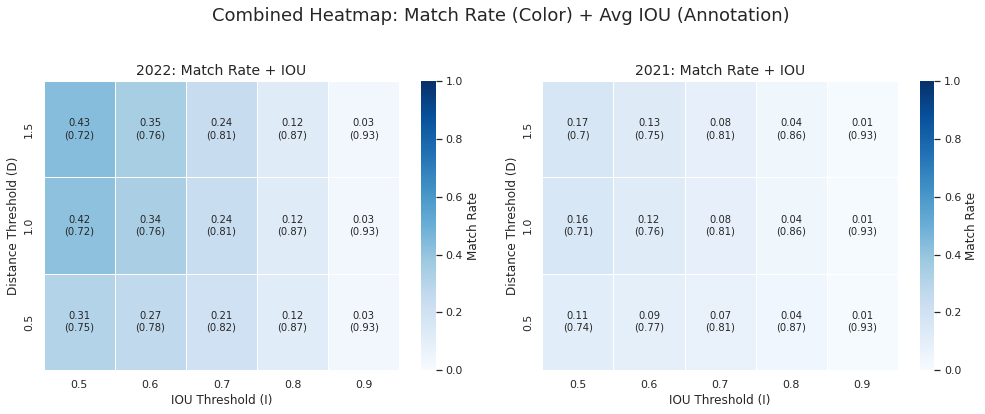

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Prepare data ---
plot_df = grid_summary_df.copy()

# Extract numeric thresholds
plot_df["D_val"] = plot_df["Thresholds"].apply(lambda x: float(x.split("_")[0].replace("D", "")))
plot_df["I_val"] = plot_df["Thresholds"].apply(lambda x: float(x.split("_")[1].replace("I", "")))

# Compute match rate
plot_df["Match_Rate"] = plot_df["Matched"] / plot_df["Total_2023"]

# Sort years (e.g., 2022, 2021)
years = sorted(plot_df["Year"].unique(), reverse=True)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(7 * len(years), 6))
plt.suptitle("Combined Heatmap: Match Rate (Color) + Avg IOU (Annotation)", fontsize=18)

for idx, year in enumerate(years):
    year_df = plot_df[plot_df["Year"] == year]

    # Pivot matrices
    pivot_rate = year_df.pivot(index="D_val", columns="I_val", values="Match_Rate")
    pivot_iou  = year_df.pivot(index="D_val", columns="I_val", values="Avg_IOU")

    # Sort axes
    pivot_rate = pivot_rate.sort_index(ascending=False).sort_index(axis=1)
    pivot_iou  = pivot_iou.loc[pivot_rate.index, pivot_rate.columns]

    # Annotation text: rate + IOU
    annotation = pivot_rate.round(2).astype(str) + "\n(" + pivot_iou.round(2).astype(str) + ")"

    # Plot
    ax = plt.subplot(1, len(years), idx + 1)
    sns.heatmap(
        pivot_rate,
        annot=annotation,
        fmt="",
        cmap="Blues",
        vmin=0,
        vmax=1,
        cbar_kws={"label": "Match Rate"},
        linewidths=0.5,
        ax=ax
    )

    ax.set_title(f"{year}: Match Rate + IOU", fontsize=14)
    ax.set_xlabel("IOU Threshold (I)")
    ax.set_ylabel("Distance Threshold (D)")

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()
